# Let´s do some explorations on different optimization use cases

Ressources: https://towardsdatascience.com/how-to-develop-optimization-models-in-python-1a03ef72f5b4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pulp
from pulp import *
from geneticalgorithm import geneticalgorithm as ga

## Use Case 1 - Maximize Profit in a Bakery:
- A bakery makes cakes and pies every day. 
- It can make a total of 30 items in one day, which at least must be 5 cakes and 10 pies for its planned customers. 
- The 400m_gains on each cake is $1.5 and the 400m_gains on each pie is $2.00. 
- How many cakes and pies should be made to maximize the 400m_gains?

### Solution Approach #1: Monte-Carlo Simulation using Random Search

In [2]:
cakes = []
pies = []
profits = []
n = 1000
# loop over random number of cakes between 0<= c <=30
for _ in range(n):
    c = int(np.random.uniform(low=0, high=30, size=1)) 
    # loop over random number of pies between 0<= p <=30
    for _ in range(n):
        p = int(np.random.uniform(low=0, high=30, size=1))
        # check boundary conditions
        if c + p <= 30 and c>=5 and p>=10:
            profit = 1.5*c + 2.0*p
            cakes.append(c)
            pies.append(p)
            profits.append(profit)

# make dataframe
d = {'cakes': cakes, 'pies': pies, 'profit': profits}
mcs_results = pd.DataFrame(data=d)
# drop duplicates
mcs_results = mcs_results.drop_duplicates()
# sort by profits
mcs_results = mcs_results.sort_values(by='profit', ascending=False) 
# find best parameters to optimize profit
p_opt = int(mcs_results.iloc[0,:].pies)
c_opt  = int(mcs_results.iloc[0,:].cakes)
profit_max = mcs_results.iloc[0,:].profit
print('The bakery should bake {} pies and {} cakes to maximize profit of {} $'.format(p_opt, c_opt, profit_max))        

The bakery should bake 25 pies and 5 cakes to maximize profit of 57.5 $


In [3]:
# find maximum profit
mcs_results.head(5)

,cakes,pies,profit
3411,5,25,57.5
2928,6,24,57.0
12,7,23,56.5
11830,8,22,56.0
1481,9,21,55.5


In [4]:
fig = px.histogram(mcs_results, x='profit')
fig.update_layout(width=500,height=500)
fig.show()

In [5]:
mcs_results_mat = mcs_results.pivot(index='cakes', columns='pies')['profit'].fillna(0)
mcs_results_mat

pies,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
cakes,,,,,,,,,,,,,,,,
5,27.5,29.5,31.5,33.5,35.5,37.5,39.5,41.5,43.5,45.5,47.5,49.5,51.5,53.5,55.5,57.5
6,29.0,31.0,33.0,35.0,37.0,39.0,41.0,43.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,0.0
7,30.5,32.5,34.5,36.5,38.5,40.5,42.5,44.5,46.5,48.5,50.5,52.5,54.5,56.5,0.0,0.0
8,32.0,34.0,36.0,38.0,40.0,42.0,44.0,46.0,48.0,50.0,52.0,54.0,56.0,0.0,0.0,0.0
9,33.5,35.5,37.5,39.5,41.5,43.5,45.5,47.5,49.5,51.5,53.5,55.5,0.0,0.0,0.0,0.0
10,35.0,37.0,39.0,41.0,43.0,45.0,47.0,49.0,51.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0
11,36.5,38.5,40.5,42.5,44.5,46.5,48.5,50.5,52.5,54.5,0.0,0.0,0.0,0.0,0.0,0.0
12,38.0,40.0,42.0,44.0,46.0,48.0,50.0,52.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,39.5,41.5,43.5,45.5,47.5,49.5,51.5,53.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
fig = px.imshow(mcs_results_mat, x=mcs_results_mat.columns, y=mcs_results_mat.index)
fig.update_layout(width=500,height=500)
fig.show()

### Solution Approach #2: Linear Optimization using PuLP

In [7]:
model = LpProblem('Maximize Bakery Profits', sense= LpMaximize)

c:\Users\Sebas\anaconda3\envs\optimization_env\lib\site-packages\pulp\pulp.py:1352: UserWarning:

Spaces are not permitted in the name. Converted to '_'



In [8]:
# define decision variables
c = LpVariable('C', lowBound=0, upBound=None, cat='Integer')
p = LpVariable('P', lowBound=0, upBound=None, cat='Integer')

In [9]:
# define constraints
model += c + p <= 30 # at least 30 items
model += c >= 5 # at least 5 cakes
model += p >= 10 # at least 10 pies

In [10]:
def objective_fun(c, p):
    return 1.5 * c + 2.0 * p

In [11]:
# define objective function
#model += 1.5 * c + 2.0 * p
model += objective_fun(c, p)

In [12]:
model

Maximize_Bakery_Profits:
MAXIMIZE
1.5*C + 2.0*P + 0.0
SUBJECT TO
_C1: C + P <= 30

_C2: C >= 5

_C3: P >= 10

VARIABLES
0 <= C Integer
0 <= P Integer

In [13]:
# solve model
print('solve model...')
print('model status: ', LpStatus[model.status])
model.solve()
print('model status: ', LpStatus[model.status])
print('optimized number of cakes: ', int(c.varValue))
print('optimized number of pies: ', int(p.varValue))
print('maximized price: ', value(model.objective))

solve model...
model status:  Not Solved
model status:  Optimal
optimized number of cakes:  5
optimized number of pies:  25
maximized price:  57.5


## Use Case 2 - Personnel Optimization in a Post Office:
- A post office is looking to hire postman, with the requirements to work 5 consecutive days and then 2 days off. 
- The estimated least number of postmen needed for each day of the week is: Monday: 25, Tuesday: 32, Wednesday: 22, Thursday: 18, Friday: 24, Saturday: 12, Sunday: 14
- The objective is to hire the minimum number of workers

To solve this problem, we need to write down the constraints in terms of the number of workers we need to start working on each day such as; x_0 is the number of workers starting to work on Monday, x_1 is the number of workers starting to work on Tuesday, etc. By doing so, we can store x_0 from Monday to Friday and x_1 from Tuesday to Saturday since they need to work 5 consecutive days

### Solution Approach #1: Monte-Carlo Simulation using Random Search

In [14]:
# let´s treat the number of workers for each week day as independent variables
workers_mon = []
workers_tue = []
workers_wed = []
workers_thu = []
workers_fri = []
workers_sat = []
workers_sun = []
workers = []

ntrials = 10000
for trial in range(ntrials):
    daily_workers = [int(n) for n in np.random.uniform(low=[0,0,0,0,0,0,0], high=[25,32,22,18,24,12,14], size=7)]
    wmon = daily_workers[0]
    wtue = daily_workers[1]
    wwed = daily_workers[2]
    wthu = daily_workers[3]
    wfri = daily_workers[4]
    wsat = daily_workers[5]
    wsun = daily_workers[6]

    # check boundary conditions          
    cond0 = wmon + wthu + wfri + wsat + wsun >= 25
    cond1 = wmon + wtue + wfri + wsat + wsun >= 32
    cond2 = wmon + wthu + wwed + wsat + wsun >= 22
    cond3 = wmon + wthu + wwed + wthu + wsun >= 18
    cond4 = wmon + wthu + wwed + wthu + wfri >= 24
    cond5 = wtue + wwed + wthu + wfri + wsat >= 12
    cond6 = wwed + wthu + wfri + wsat + wsun >= 14
                            
    if cond0 and cond1 and cond2 and cond3 and cond4 and cond5 and cond6:
        # total number of workers
        num_workers = wmon+wtue+wwed+wthu+wfri+wsat+wsun
        # print current number of minimal workers
        if len(workers)>0 and num_workers < np.min(workers):
            print(num_workers)
        # append number of workers for each week day
        workers_mon.append(wmon)
        workers_tue.append(wtue)
        workers_wed.append(wwed)
        workers_thu.append(wthu)
        workers_fri.append(wfri)
        workers_sat.append(wsat)
        workers_sun.append(wsun)
        workers.append(num_workers)

92
64
63
57
53
52
50
43
40
38
36


In [15]:
# make dataframe
d = {'monday': workers_mon, 
     'tuesday': workers_tue,
     'wednesday': workers_wed,
     'thursday': workers_thu,
     'friday': workers_fri,
     'saturday': workers_sat,
     'sunday': workers_sun, 
     'total workers': workers}
mcs_results = pd.DataFrame(data=d)

# drop duplicates
mcs_results = mcs_results.drop_duplicates()

# sort by number of total workers
mcs_results = mcs_results.sort_values(by='total workers', ascending=True)
mcs_results.head()

,monday,tuesday,wednesday,thursday,friday,saturday,sunday,total workers
7626,17,4,2,0,9,1,3,36
5077,14,3,4,1,8,0,8,38
3211,15,2,7,1,12,2,1,40
144,18,3,2,1,2,4,10,40
7238,17,6,5,1,1,10,0,40


### Solution Approach #2: Linear Optimization using PuLP

In [16]:
#Initialize model
model = LpProblem("Minimize Number of Workers", LpMinimize)
#Define decision variables
days = list(range(7))

c:\Users\Sebas\anaconda3\envs\optimization_env\lib\site-packages\pulp\pulp.py:1352: UserWarning:

Spaces are not permitted in the name. Converted to '_'



In [17]:
x = LpVariable.dicts('workers_', days, lowBound=0, upBound=None, cat='Integer')

In [18]:
x

{0: workers__0,
 1: workers__1,
 2: workers__2,
 3: workers__3,
 4: workers__4,
 5: workers__5,
 6: workers__6}

In [19]:
[x[i] for i in days]

[workers__0,
 workers__1,
 workers__2,
 workers__3,
 workers__4,
 workers__5,
 workers__6]

In [20]:
# Define objective function/model
model += lpSum([x[i] for i in days])

In [21]:
# Define constraints
model += x[0] + x[3] + x[4] + x[5] + x[6] >= 25
model += x[0] + x[1] + x[4] + x[5] + x[6] >= 32
model += x[0] + x[1] + x[2] + x[5] + x[6] >= 22
model += x[0] + x[1] + x[2] + x[3] + x[6] >= 18
model += x[0] + x[1] + x[2] + x[3] + x[4] >= 24
model += x[1] + x[2] + x[3] + x[4] + x[5] >= 12
model += x[2] + x[3] + x[4] + x[5] + x[6] >= 14

In [22]:
# Solve model
model.solve()
#Print model status
print('Status:', LpStatus[model.status])

Status: Optimal


In [23]:
# Print solution variables
for variable in model.variables():
    print ('{} = {}'.format(variable.name, variable.varValue))

workers__0 = 7.0
workers__1 = 7.0
workers__2 = 0.0
workers__3 = 0.0
workers__4 = 10.0
workers__5 = 0.0
workers__6 = 8.0


In [24]:
# The least total number of workers required is: 
workers = 0
for variable in model.variables():
    workers += variable.varValue
print('The least total number of workers required is: ', int(workers))

The least total number of workers required is:  32


### Solution Approach #3: Genetic Algorithm Optimization

 The best solution found:                                                                           
 [9. 7. 0. 0. 9. 2. 5.]

 Objective function:
 32.0


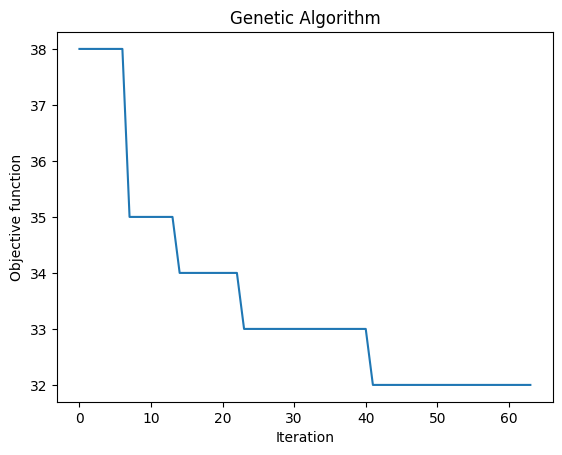

In [25]:
# define parameters
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':1000,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':20}
# define variables
varbound=np.array([[0,25],[0,32],[0,22],[0,18],[0,24],[0,12],[0,14]])
vartype=np.array([['int'],['int'],['int'],['int'],['int'],['int'],['int']])

# define objective function
def f(x):
    cond0 = x[0] + x[3] + x[4] + x[5] + x[6] < 25 
    cond1 = x[0] + x[1] + x[4] + x[5] + x[6] < 32
    cond2 = x[0] + x[1] + x[2] + x[5] + x[6] < 22
    cond3 = x[0] + x[1] + x[2] + x[3] + x[6] < 18
    cond4 = x[0] + x[1] + x[2] + x[3] + x[4] < 24
    cond5 = x[1] + x[2] + x[3] + x[4] + x[5] < 12
    cond6 = x[2] + x[3] + x[4] + x[5] + x[6] < 14
    
    violation0 = x[0] + x[3] + x[4] + x[5] + x[6] - 25
    violation1 = x[0] + x[1] + x[4] + x[5] + x[6] - 32
    violation2 = x[0] + x[1] + x[2] + x[5] + x[6] - 22
    violation3 = x[0] + x[1] + x[2] + x[3] + x[6] - 18
    violation4 = x[0] + x[1] + x[2] + x[3] + x[4] - 24
    violation5 = x[1] + x[2] + x[3] + x[4] + x[5] - 12
    violation6 = x[2] + x[3] + x[4] + x[5] + x[6] - 14
    
    # apply a penalty each time the contraints are met
    if cond0 or cond1 or cond2 or cond3 or cond4 or cond5 or cond6:
        penalty = violation0**2 + violation1**2  + violation2**2  + violation3**2  + violation4**2  + violation5**2  + violation6**2
        return np.sum(x) + penalty
    else:
        return np.sum(x) 

model = ga(function=f,
         dimension=7, # one variable for each day of the week
         variable_type_mixed=vartype,
         variable_boundaries=varbound,
         algorithm_parameters=algorithm_param)

model.run()

## Use Case 3 - Training Optimization using PuLP
- Optimize weekly training by maximizing both endurance and strength

In [26]:
exercise = ['Push','Pull','I1-Run','I2-Runs','I3-Runs','NI-Runs']
impact = {'Push':33, 'Pull':33, 'I1-Run':100, 'I2-Runs':120, 'I3-Runs':80, 'NI-Runs':60} # impact referenced to one full-out tempo run e.g. 1x300m
benefit_endurance = {'Push':0, 'Pull':0, 'I1-Run':40, 'I2-Runs':60, 'I3-Runs':80, 'NI-Runs':100} # general endurance benefit
benefit_strength = {'Push':50, 'Pull':50, 'I1-Run':20, 'I2-Runs':25, 'I3-Runs':0, 'NI-Runs':0} # benefit in strength

# Initialize Class
model = LpProblem("Maximizing 400m Performance", LpMaximize)

# Define Decision Variables
x = LpVariable.dicts('exercise_', exercise, cat='Binary') # binary decision var meaning either do exercise or don´t

# Define Objective
model += lpSum([benefit_endurance[i]*x[i] for i in exercise]) + 0.5*lpSum([benefit_strength[i]*x[i] for i in exercise])

# Define Constraints
model += lpSum([impact[i]*x[i] for i in exercise]) <= 130 # limit total impact
model += x['I1-Run'] + x['I2-Runs'] + x['I3-Runs'] == 1 # choose either I1-run, I2-runs or I3-runs
model += x['I1-Run'] - x['Push'] <= 0 # if I1-run is selected, then also do Push
#model += x['Push'] == 1 # in any case (not!) do Push exercise
#model += x['Pull'] == 0 # in any case (not!) do Pull exercise
#model += x['I1-Run'] == 1 # in any case (not!) do I1-run
#model += x['I2-Runs'] == 1 # in any case (not!) do I2-runs
#model += x['I3-Runs'] == 1 # in any case (not!) do I3-runs
#model += x['NI-Runs'] == 1 # in any case (not!) do NI-runs

# Solve Model
model.solve()

# Print status
print('Model Status: ', LpStatus[model.status])

# Print variables
for v in model.variables():
    print(v.name, "=", v.varValue)

# Print Objective Fun. Value
print("Total Benefit = ", value(model.objective))

Model Status:  Optimal
exercise__I1_Run = 0.0
exercise__I2_Runs = 0.0
exercise__I3_Runs = 1.0
exercise__NI_Runs = 0.0
exercise__Pull = 1.0
exercise__Push = 0.0
Total Benefit =  105.0


## Use Case 4 - Supply Chain Analytics using PuLP
- Minimize Costs

Ressources: 
https://campus.datacamp.com/courses/supply-chain-analytics-in-python/basics-of-supply-chain-optimization-and-pulp

In [27]:
# import fix_costs data
fix_cost = pd.read_csv('../data/fixcosts.csv', 
                      sep=';',
                      index_col='Supply_Region')
fix_cost.head()


,Low_Cap,High_Cap
Supply_Region,,
USA,6500,9500
Germany,4980,7270
Japan,6230,9100
Brazil,3230,4730
India,2110,3080


In [28]:
# check data type
fix_cost.dtypes

Low_Cap     int64
High_Cap    int64
dtype: object

In [29]:
# import var_costs data
var_cost = pd.read_csv('../data/varcosts.csv', 
                      sep=';',
                      index_col='Supply_Region')
var_cost.head()

,USA,Germany,Japan,Brazil,India
Supply_Region,,,,,
USA,6,13,20,12,17
Germany,13,6,14,14,13
Japan,20,14,3,21,9
Brazil,12,14,21,8,21
India,22,13,10,23,8


In [30]:
# check data type
var_cost.dtypes

USA        int64
Germany    int64
Japan      int64
Brazil     int64
India      int64
dtype: object

In [31]:
# import demand data
demand = pd.read_csv('../data/demand.csv', 
                      sep=';',
                      index_col='Supply_Region')
demand.head()

,Dmd
Supply_Region,
USA,"2719,6"
Germany,"84,1"
Japan,"1676,8"
Brazil,"145,4"
India,"156,4"


In [32]:
# check data type
demand.dtypes

Dmd    object
dtype: object

In [33]:
# adapt data type to float
demand['Dmd'] = demand['Dmd'].replace(regex=r',', value='.').astype(float)

In [34]:
# import capacity data
cap = pd.read_csv('../data/capacity.csv', 
                      sep=';',
                      index_col='Supply_Region')
cap.head()

,Low_Cap,High_Cap
Supply_Region,,
USA,500,1500
Germany,500,1500
Japan,500,1500
Brazil,500,1500
India,500,1500


In [35]:
# check data type
cap.dtypes

Low_Cap     int64
High_Cap    int64
dtype: object

In [36]:
loc = list(fix_cost.index)
size = list(fix_cost.columns)

In [37]:
# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)

# Define Decision Variables
x = LpVariable.dicts("production_", [(i,j) for i in loc for j in loc], lowBound=0, upBound=None, cat='Continuous') # fraction of e.g. thousands
y = LpVariable.dicts("plant_", [(i,s) for s in size for i in loc], cat='Binary') # is plant open or not


c:\Users\Sebas\anaconda3\envs\optimization_env\lib\site-packages\pulp\pulp.py:1352: UserWarning:

Spaces are not permitted in the name. Converted to '_'



In [38]:
# Define Objective Function
model += (lpSum([fix_cost.loc[i,s]*y[(i,s)] for s in size for i in loc]) + lpSum([var_cost.loc[i,j]*x[(i,j)] for i in loc for j in loc]))

In [39]:
# Define the Constraints
for j in loc: 
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j, 'Dmd'] # production must meet demand

for i in loc: 
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] for s in size]) # produce equal or below local capacity


In [40]:
# Solve
model.solve()

1

In [42]:
# Print Decision Variables and Objective Value
print(LpStatus[model.status])
o = [{'prod':"{} to {}".format(i,j), 'quant':x[(i,j)].varValue} for i in loc for j in loc]
print(pd.DataFrame(o))

Optimal
                  prod   quant
0           USA to USA  1500.0
1       USA to Germany     0.0
2         USA to Japan     0.0
3        USA to Brazil     0.0
4         USA to India     0.0
5       Germany to USA     0.0
6   Germany to Germany     0.0
7     Germany to Japan     0.0
8    Germany to Brazil     0.0
9     Germany to India     0.0
10        Japan to USA     0.0
11    Japan to Germany     0.0
12      Japan to Japan  1500.0
13     Japan to Brazil     0.0
14      Japan to India     0.0
15       Brazil to USA  1219.6
16   Brazil to Germany     0.0
17     Brazil to Japan     0.0
18    Brazil to Brazil   145.4
19     Brazil to India     0.0
20        India to USA     0.0
21    India to Germany    84.1
22      India to Japan   176.8
23     India to Brazil     0.0
24      India to India   156.4


In [43]:
o = [{'loc':i, 'lc':y[(i,size[0])].varValue, 'hc':y[(i,size[1])].varValue} for i in loc]
print(pd.DataFrame(o))

       loc   lc   hc
0      USA  0.0  1.0
1  Germany  0.0  0.0
2    Japan  0.0  1.0
3   Brazil  0.0  1.0
4    India  1.0  0.0


In [45]:
print("Production-Costs = ", value(model.objective))

Production-Costs =  58850.899999999994


In [46]:
# Print Shadow Price and Slack
o = [{'name':name, 'shadow price':c.pi, 'slack': c.slack} for name, c in model.constraints.items()]
print(pd.DataFrame(o))

   name  shadow price  slack
0   _C1          12.0   -0.0
1   _C2          13.0   -0.0
2   _C3          10.0   -0.0
3   _C4           8.0   -0.0
4   _C5           8.0   -0.0
5   _C6          -6.0   -0.0
6   _C7          -7.0   -0.0
7   _C8          -7.0   -0.0
8   _C9           0.0  135.0
9  _C10           0.0   82.7


In [51]:
model


Capacitated_Plant_Location_Model:
MINIMIZE
4730*plant__('Brazil',_'High_Cap') + 3230*plant__('Brazil',_'Low_Cap') + 7270*plant__('Germany',_'High_Cap') + 4980*plant__('Germany',_'Low_Cap') + 3080*plant__('India',_'High_Cap') + 2110*plant__('India',_'Low_Cap') + 9100*plant__('Japan',_'High_Cap') + 6230*plant__('Japan',_'Low_Cap') + 9500*plant__('USA',_'High_Cap') + 6500*plant__('USA',_'Low_Cap') + 8*production__('Brazil',_'Brazil') + 14*production__('Brazil',_'Germany') + 21*production__('Brazil',_'India') + 21*production__('Brazil',_'Japan') + 12*production__('Brazil',_'USA') + 14*production__('Germany',_'Brazil') + 6*production__('Germany',_'Germany') + 13*production__('Germany',_'India') + 14*production__('Germany',_'Japan') + 13*production__('Germany',_'USA') + 23*production__('India',_'Brazil') + 13*production__('India',_'Germany') + 8*production__('India',_'India') + 10*production__('India',_'Japan') + 22*production__('India',_'USA') + 21*production__('Japan',_'Brazil') + 14*produ